<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15_MaskRCNN/blob/master/EVA4P1_S15_DepthCreation_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Tue May 12 15:05:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    36W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd gdrive/My Drive/DepthProject

/content/gdrive/My Drive/DepthProject


In [4]:
!ls -l

total 4
drwx------ 2 root root 4096 May  9 17:33 DenseDepth


In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O DenseDepth/nyu.h5

--2020-05-11 12:40:07--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.106.179
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.106.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘DenseDepth/nyu.h5’

DenseDepth/nyu.h5   100%[===================>] 164.89M  23.9MB/s    in 7.7s    

2020-05-11 12:40:15 (21.4 MB/s) - ‘DenseDepth/nyu.h5’ saved [172897376/172897376]



In [5]:
ls DenseDepth

augment.py      demo_rgb.npy      LICENSE       PyTorch/     utils.py
callbacks.py    DenseDepth.ipynb  loss.py       README.md
data.py         evaluate.py       model.py      Tensorflow/
demo_depth.npy  examples/         nyu.h5        test.py
demo.py         layers.py         __pycache__/  train.py


In [6]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from matplotlib import pyplot as plt
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict

MODEL_PATH = 'DenseDepth/nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(MODEL_PATH))

Using TensorFlow backend.


Loading model...

Model loaded (DenseDepth/nyu.h5).


In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [8]:
from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import skimage
from skimage.transform import resize
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from datetime import datetime 
import gc
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!unzip -q "/content/gdrive/My Drive/EVA4P1_S15/FG_BG/FG_BG.zip"
FG_BG_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG/FG_BG.zip", 'r')

In [0]:
all_files = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]

In [0]:
len(all_files)

800008

In [0]:
FG_BG_Images = all_files[400008:]

In [0]:
len(FG_BG_Images)

400000

In [0]:
def Depth_Creation(frm,to):
    global k, depth_log 
    # Depth Creation loop
    images    = []
    file_name = []
    for fg_bg_file in FG_BG_Images[frm:to]:
        imgdata = FG_BG_zip.read(fg_bg_file)
        img = Image.open(io.BytesIO(imgdata))
        img = img.resize((640, 480)) 
        x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
        images.append(x)
        fg_bg_name = fg_bg_file.split('/')[-1].split('.')[0]  # We want to take "Img_fg_bg_184131" from 'G_BG/Img_fg_bg_184131.jpg'
        file_name.append(fg_bg_name)
    images = np.stack(images, axis=0)
    print('Going to predict')
    t1 = time()
    output = predict(model, images) 
    outputs = output.copy()
    t2 = time()   
    print(f'Model took {(t2-t1):.5f} s')

    # Depth Image saving loop
    for i in range(outputs.shape[0]):         
        op_img = outputs[i]
        op_img = resize(op_img, (200, 200))
        rescaled = op_img[:,:,0]
        rescaled = rescaled - np.min(rescaled)
        rescaled = rescaled / np.max(rescaled)
        depth    = Image.fromarray(rescaled * 255)
        depth    = depth.convert('L')
        depth_name  = file_name[i] + '_depth' + '.jpg'
        depth.save(f'{path_fg_bg_depth}{depth_name}')
        string = f'{depth_name},{file_name[i]}' + '\n'
        depth_log.write(string)
        k += 1

    # cleanup files
    del output, outputs, images

    # garbage collect
    gc.collect()
    return k   

In [0]:
x        = 0
delta    = 1000
iter_lst = []
for i in range(400):
    x1, y1 = x, x+delta
    tup = (x1,y1)
    iter_lst.append(tup)
    x = y1

In [0]:
iter_lst_200_300 = iter_lst[200:300]

In [0]:
iter_lst_200_300[0]

(200000, 201000)

In [0]:
iter_lst_200_300[-1]

(299000, 300000)

In [0]:
len(iter_lst_200_300)

100

In [0]:
k = 0
path_fg_bg_depth='/content/sample_data/ Use_FG_BG_Depth_200_300K/'

In [0]:
#(300,000 to  400,000)
for i in range(len(iter_lst_200_300)):
    t3 = time()
    frm, to           = iter_lst_200_300[i]
    depth_log         = open('/content/sample_data/ Use_Log_Depth_200_300K.txt', "a")
    k = Depth_Creation(frm,to)
    print('Depth Images created so far:',k, datetime.now())
    depth_log.close()
    t4 = time()
    print(f'Iteration took {(t3-t4):.5f} s')    

Going to predict
Model took 63.35793 s
Depth Images created so far: 1000 2020-05-11 16:04:02.019535
Iteration took -87.42458 s
Going to predict
Model took 62.78397 s
Depth Images created so far: 2000 2020-05-11 16:05:20.289988
Iteration took -78.27074 s
Going to predict
Model took 62.89527 s
Depth Images created so far: 3000 2020-05-11 16:06:39.707757
Iteration took -79.41784 s
Going to predict
Model took 62.88712 s
Depth Images created so far: 4000 2020-05-11 16:08:00.012967
Iteration took -80.30505 s
Going to predict
Model took 62.76999 s
Depth Images created so far: 5000 2020-05-11 16:09:19.826968
Iteration took -79.81396 s
Going to predict
Model took 62.85570 s
Depth Images created so far: 6000 2020-05-11 16:10:38.746365
Iteration took -78.91921 s
Going to predict
Model took 62.78048 s
Depth Images created so far: 7000 2020-05-11 16:11:57.350477
Iteration took -78.60377 s
Going to predict
Model took 62.87440 s
Depth Images created so far: 8000 2020-05-11 16:13:16.266118
Iteration t

In [0]:
## Script for deletion of files from colab folder '  FG_BG_Depth_300_400K', because these files are duplicates
import os
path_del   = '/content/sample_data/ FG_BG_Depth_300_400K/'
k = 0
for del_file in os.listdir(path_del):
    os.remove(f'{path_del}{del_file}')
    k += 1
print('total deleted from  FG_BG_Depth_300_400K:',k)

total deleted from  FG_BG_Depth_300_400K: 0


In [0]:
## Script for deletion of files from colab folder '  FG_BG_Depth_398_400K', because these files are duplicates
import os
path_del   = '/content/sample_data/ FG_BG_Depth_398_400K/'
k = 0
for del_file in os.listdir(path_del):
    os.remove(f'{path_del}{del_file}')
    k += 1
print('total deleted from  FG_BG_Depth_398_400K:',k)

total deleted from  FG_BG_Depth_398_400K: 0


In [0]:
zipname_fg_bg_depth = ' FG_BG_Depth_200_300K'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

In [0]:
# Checking current directory 
!pwd

/content/gdrive/My Drive/DepthProject


In [0]:
# Repointing to gdrive directory where we need to route the zip file
os.chdir('/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth')

In [0]:
!pwd

/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth


In [0]:
#Running zip command. This will zip all the files available in 'sample_data' & place in current directory
zipfolder(zipname_fg_bg_depth, '/content/sample_data/')

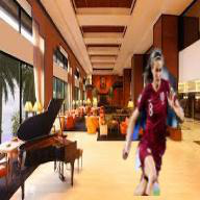

In [0]:
# Random check of original FG_BG Image
imgdata = FG_BG_zip.read('G_BG/Img_fg_bg_155634.jpg')
img = Image.open(io.BytesIO(imgdata))
img = img.resize((200, 200)) 
img

Depth Images are scattered across 3 zip files. Below code section brings them together to a single location. First 201007 files have 1000 duplicates & 7 unwanted. They are also removed below.

In [0]:
Depth_200K_zip     =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth/FG_BG_Depth_200K.zip", 'r')
Depth_200_300K_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth/FG_BG_Depth_200_300K.zip", 'r')
Depth_300_400K_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth/FG_BG_Depth_300_400K.zip", 'r')

In [0]:
Depth_200K_all_files     = [info.filename for info in Depth_200K_zip.infolist() if not info.is_dir()]
Depth_200_300K_all_files = [info.filename for info in Depth_200_300K_zip.infolist() if not info.is_dir()]
Depth_300_400K_all_files = [info.filename for info in Depth_300_400K_zip.infolist() if not info.is_dir()]

In [56]:
print('len(Depth_200K_all_files):',len(Depth_200K_all_files))
print('len(Depth_200_300K_all_files):',len(Depth_200_300K_all_files))
print('len(Depth_300_400K_all_files):',len(Depth_300_400K_all_files))

len(Depth_200K_all_files): 201007
len(Depth_200_300K_all_files): 100000
len(Depth_300_400K_all_files): 100000


In [0]:
path_file = '/content/sample_data/ FG_BG_Depth_0_400K/'
file_log  = open('/content/sample_data/ Log_FG_BG_Depth_0_400K.txt',"w")

In [58]:
k = 0
file_log = open('/content/sample_data/ Log_FG_BG_Depth_0_400K.txt',"a")
for img_file in Depth_200K_all_files[0:]:
    if img_file.endswith('jpg'):
      if img_file[0:12] == 'FG_BG_Depth/':
        continue
      else:  
        imgdata = Depth_200K_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_file}{file_name}')
        string = file_name + '\n'
        file_log.write(string)
        k += 1
file_log.close()   
print( 'Depth_200K, Images Captured:',k)

Depth_200K, Images Captured: 200000


In [59]:
file_log = open('/content/sample_data/ Log_FG_BG_Depth_0_400K.txt',"a")
for img_file in Depth_200_300K_all_files[0:]:
    if img_file.endswith('jpg'):
        imgdata = Depth_200_300K_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_file}{file_name}')
        string = file_name + '\n'
        file_log.write(string)
        k += 1
file_log.close()   
print( 'Depth_200_300K, Images Captured:',k)

Depth_200_300K, Images Captured: 300000


In [60]:
file_log = open('/content/sample_data/ Log_FG_BG_Depth_0_400K.txt',"a")
for img_file in Depth_300_400K_all_files[0:]:
    if img_file.endswith('jpg'):
        imgdata = Depth_300_400K_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_file}{file_name}')
        string = file_name + '\n'
        file_log.write(string)
        k += 1
file_log.close()   
print( 'Depth_300_400K, Images Captured:',k)

Depth_300_400K, Images Captured: 400000


In [61]:
# Verifying that all 400K files reached the folder
k = 0
for file_name in os.listdir(path_file):
    k += 1
print('total files in FG_BG_Depth_0_400K:',k)

total files in FG_BG_Depth_0_400K: 400000


In [0]:
zipname_fg_bg_depth = ' FG_BG_Depth_0_400K'

In [63]:
!pwd

/content


In [0]:
os.chdir('/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth')

In [65]:
!pwd

/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth


In [0]:
zipfolder(zipname_fg_bg_depth, '/content/sample_data/')

##Depth Creation for 100 BG images and 100 BG_Flip Images and saving it in a zip file

In [0]:
FG_BG_zip =  ZipFile("/content/gdrive/My Drive/BG_and_Its Flip Images.zip", 'r')
bg_flip_files = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]

In [14]:
bg_flip_files[0]

'BG_and_Its Flip Images/Img1.jpg'

In [0]:
def BG_Depth_Creation():
    global k, bg_depth_log 
    # Depth Creation loop
    images    = []
    file_name = []
    for bg_file in bg_flip_files[0:]:
        imgdata = FG_BG_zip.read(bg_file)
        img = Image.open(io.BytesIO(imgdata))
        img = img.resize((640, 480)) 
        x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
        images.append(x)
        bg_depth_name = bg_file.split('/')[-1].split('.')[0]  # We want to take "Img_fg_bg_184131" from 'G_BG/Img_fg_bg_184131.jpg'
        file_name.append(bg_depth_name)
    images = np.stack(images, axis=0)
    print('Going to predict')
    t1 = time()
    output = predict(model, images) 
    outputs = output.copy()
    t2 = time()   
    print(f'Model took {(t2-t1):.5f} s')

    # Depth Image saving loop
    for i in range(outputs.shape[0]):         
        op_img = outputs[i]
        op_img = resize(op_img, (200, 200))
        rescaled = op_img[:,:,0]
        rescaled = rescaled - np.min(rescaled)
        rescaled = rescaled / np.max(rescaled)
        depth    = Image.fromarray(rescaled * 255)
        depth    = depth.convert('L')
        depth_name  = file_name[i] + '_depth' + '.jpg'
        depth.save(f'{path_bg_depth}{depth_name}')
        string = f'{depth_name},{file_name[i]}' + '\n'
        bg_depth_log.write(string)
        k += 1

    # cleanup files
    del output, outputs, images

    # garbage collect
    gc.collect()
    return k   

In [0]:
k = 0
path_bg_depth ='/content/sample_data/ BG_Depth/'

In [18]:
#(100 BG & 100 BG_Flip)
for i in range(len(path_list)):
    t3 = time()
    bg_depth_log      = open('/content/sample_data/ Log_Depth_BG.txt', "a")
    k = BG_Depth_Creation()
    print('Depth Images created so far:',k, datetime.now())
    bg_depth_log.close()
    t4 = time()
    print(f'Iteration took {(t3-t4):.5f} s')  

Going to predict
Model took 67.62132 s
Depth Images created so far: 200 2020-05-12 15:46:47.917142
Iteration took -72.28043 s


In [19]:
!pwd

/content/gdrive/My Drive/DepthProject


In [0]:
zipname_fg_bg_depth = ' BG_Depth'

In [0]:
os.chdir('/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth')

In [22]:
!pwd

/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Depth


In [0]:
zipfolder(zipname_fg_bg_depth, '/content/sample_data/')